In [1]:
# ESSENTIALS
import numpy as np
import matplotlib.pyplot as plt
import glob, os
from datetime import datetime

# CLUSTERING AND RANDOM FOREST
import skfuzzy as fuzz
from sklearn import tree
from sklearn import model_selection
from sklearn.datasets import make_blobs
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.svm import *
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay

# DATA LIBRARIES
# import rasterio
# import contextily as cx
import geopandas as gpd
import pandas as pd
import json
import pickle
import xarray
from xarray.core.dataarray import DataArray


# PREFERENCES
pd.set_option('display.max_columns', 500)
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

In [2]:
class ModelSelector():

    def __init__(self, c_kwargs={}, rf_kwargs={}):
       self.c_kwargs=c_kwargs        # CLUSTERING HYPERPARAMETERS
       self.rf_kwargs=rf_kwargs      # RANDOM FOREST HYPERPARAMETERS
       self.m = 2                    # EXPONENTIATION COEFFICIENT FOR CLUSTERING. TODO: MAKE ADJUSTABLE

    def fuzzyCluster(self, data):
        # Wraps Fuzzy Cluster function, only outputting percent belongs and formal cluster.

        # CHECK THAT REQUIRED FIELDS ARE IN KWARGS, IF NOT ADD
        if "error" not in self.c_kwargs:
            self.c_kwargs['error']=0.005

        if "maxiter" not in self.c_kwargs:
            self.c_kwargs['maxiter']=1000

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, self.n_centers, self.m, **self.c_kwargs)
        label = np.argmax(u, axis=0)
        return cntr, u, fpc, label

    def howManyClusters(self, X, mintest=2,maxtest=15):
        # Determines how many clusters should be used using the Fuzzy Partitions Coefficient (FPC)
        # https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
        # TODO: FIGURE OUT IF THIS METHOD IS APPROPRIATE OR NOT
        return 3
        fpcs = []
        listtests = np.arange(mintest,maxtest)
        for ncenters in listtests:
            self.n_centers = ncenters
            _, _, fpc, _ = self.fuzzyCluster(X)
            fpcs.append(fpc)
        return listtests[np.argmax(fpcs)]

    def train_rf(self, X_train, y_train, rf_controls={}):
        # ADAPTED FROM https://stackoverflow.com/questions/28489667/combining-random-forest-models-in-scikit-learn

        # RF CONTROLS PASSED DIRECTLY FROM PARAMETER, DEFAULT IS EMPTY
        rf = RandomForestRegressor(**rf_controls) 

        # RF FITTING 
        rf.fit(X_train, y_train)

        return rf

    def fit(self, attributes, model_perf):

        # CREATE RANDOM FOREST AND TRAIN
        self.rf = self.train_rf(attributes, model_perf, rf_controls=self.rf_kwargs)
        # print(r2_score(self.rf.predict(attributes), model_perf))

        return self

    def predict(self, attributes):

        # CHECK WHETHER MODEL HAS BEEN TRAINED
        if self.rf is None:
            raise(Exception("ModelSelector isn't trained!"))

        # GET RANDOM FOREST PREDICTION
        pred = self.rf.predict(attributes)


        return pred

In [3]:
# ADAPTED FROM https://github.com/neuralhydrology/neuralhydrology/blob/1ff36ea8c8eff99ad25fa0f56f0119acbc9e6799/neuralhydrology/evaluation/metrics.py
def nse(obs: DataArray, sim: DataArray) -> float:
    denominator = ((obs - obs.mean())**2).sum()
    numerator = ((sim - obs)**2).sum()
    value = 1 - numerator / denominator
    return float(value)

def getNNSEfromNWM():
    
    # DEFINE DIR WITH ALL STREAMFLOW DATA 
    q_dir = "/home/ottersloth/data/camels_hourly/usgs_streamflow"
    
    # TEST PERIOD
    test_start=datetime.strptime("2002-09-30 23:00:00", '%Y-%m-%d %H:%M:%S')
    # ORIGINALLY UNTIL 11 PM, CHANGED BECAUSE COMPARISON FUNCTION IS INCLUSIVE LATER ON
    test_end=datetime.strptime("2007-09-30 22:00:00", '%Y-%m-%d %H:%M:%S') 
    
    # DEFINE AND READ IN NWM TIMESERIES
    nwmdir = "/home/ottersloth/cfe_calibration/NWM_streamflow_results.csv"
    nwm = pd.read_csv(nwmdir)
    
    # GET BASINS IN DATASET, REMOVE FIRST COLUMN NAME BC IT'S D
    basins = nwm.columns.to_list()[1:]
    
    # CONTAINER FOR OUTPUT
    nnsedf = list()
    
    # LOOP THROUGH BASINS IN DATASET
    for currbasin in basins:
        try:
        
            basinid = currbasin

            # GET MODEL PREDICTION IN CURRENT BASINS
            pred = nwm[currbasin].to_numpy()

            # GET Q FROM USGS FOR TEST PERIOD
            q_read = pd.read_csv(f"{q_dir}/{basinid}-usgs-hourly.csv")
            q_read["datetime"] = pd.to_datetime(q_read['date'], format='%Y-%m-%d %H:%M:%S') # CONVERT TO DATETIME
            q_match = q_read[q_read.datetime.between(test_start, test_end)]
            ts_q = q_match['QObs_CAMELS(mm/h)'].to_numpy()

            # CALCULATE NSE 
            nse_calc = nse(ts_q, pred)

            # CALCULATE NNSE
            nnse = 1 / (2 - nse_calc)

            # APPEND TO CONTAINER
            # df_add = {currbasin: nnse}
            df_add = list(np.array([currbasin, nnse]))
            
            nnsedf.append(df_add)
            print(df_add)
            
        
        except: 
            continue
            
    nnsedf = pd.DataFrame(np.array(nnsedf), columns=["basin_id", "nnse"])
    nnsedf.to_csv(r"/home/ottersloth/ensemblennse/data/data/hourly_performances/nwm.csv")
    
    
    return nnsedf

# nwm_nnse = getNNSEfromNWM()
    

In [4]:
def getFeatureImportance(selector, testidx, input, output, xx, reps=10):
    # USING FULL PERMUTATION IMPORTANCE, AS OUTLINED IN 
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    result = permutation_importance(selector.rf, input.iloc[testidx, :], output.iloc[testidx], n_repeats=reps, random_state=42, n_jobs=2)
    means = pd.Series(result.importances_mean, index=list(input)) 
    std = pd.Series(result.importances_std, index=list(input))
    df = pd.concat([means, std], axis=1)
    df.columns = [str(xx) + "_mean", str(xx) + "_std"]
    return df


def runFitMetric_getMSE(fitmet, rf_kwargs={}):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    # camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"
    camelsdir = r"/home/ottersloth/ensemblennse/data/data/HCDN_nhru_final/HCDN_nhru_final_671.shp"
    
    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"/home/ottersloth/ensemblennse/data/data/camels_attributes_v2.0/camels_attributes_v2.0/"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob.glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    # perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\"
    perf_dir = r"/home/ottersloth/ensemblennse/data/data/hourly_performances/"
    
    perf_metrics = [fitmet]

    # READ ALL CSV FILES IN DIRECTORY
    os.chdir(perf_dir)
    modelfiles = glob.glob("*.csv")

    # GET FIRST CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
    print(perf_dir + modelfiles[0])
    perf = pd.read_csv(perf_dir + modelfiles[0]).add_prefix(modelfiles[0][:-4] + "_")
    # GET COLUMN NAME CONTAINING "BASIN"
    fcol = [col for col in perf.columns if 'basin' in col]

    # LOOP FOR EACH CSV FILE
    for ii in range(1, len(modelfiles)):
        print(perf_dir + modelfiles[ii])
        # GET NEXT CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
        currdf = pd.read_csv(perf_dir + modelfiles[ii]).add_prefix(modelfiles[ii][:-4] + "_")

        # GET COLUMN NAME CONTAINING "BASIN"
        basin_col= [col for col in currdf.columns if 'basin' in col]
        # JOIN ON MATCHING BASINS
        perf = perf.merge(currdf, how="inner", left_on=fcol, right_on=basin_col)
    
    # GET COLUMN NAME CONTAINING "FITMET"
    perf_met = [col for col in perf.columns if fitmet in col]

    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['organic_frac',
    'elev_mean_x',
    'slope_mean',
    'area_gages2',
    'soil_depth_pelletier',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur']

    camels_df = camels_df.merge(perf, how="inner", left_on="hru_id", right_on=fcol)
    
    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perf_met]
    
    
    nsplits = 5
    kf = KFold(n_splits=nsplits, shuffle=True)


    testvalues = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                  # CONTAINER FOR PERFORMANCE VALUES WHEN BASIN IN TEST SET
    modelno = 0                                                              # COUNTER FOR MODEL CONTAINER
    test_modelno = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                # MODEL IN WHICH BASIN WAS IN TEST SET
    test_modellist = list()                                                  # MODEL CONTAINER
    featureimportance = list()
    r2train = list()
    r2test = list()
    msetest = list()
    msetrain = list()
    msemeta = list()
    trainlist_x = list()
    trainlist_y = list()

    currout=outputdataset

    # KFOLD SPLIT OF DATASETS
    for train, test in kf.split(inputdataset):            
        # CODE FOR INDIVIDUAL MODEL TRAINING
        for ii in range(currout.shape[1]):
            # TRAIN MODEL ON TRAINING SET
            model = None
            model = ModelSelector(rf_kwargs=rf_kwargs)
            model.fit(inputdataset.iloc[train, :], currout.iloc[train, ii])

            # PERFORM PREDICTION ON TRAIN SET AND GET FIT METRICS
            train_pred = model.predict(inputdataset.iloc[train, :])
            trainrms = mse(train_pred, currout.iloc[train, ii].to_numpy())
            trainr2 = r2_score(train_pred, currout.iloc[train, ii].to_numpy())

            # PERFORM PREDICTION ON TEST SET AND GET FIT METRICS
            model_pred = model.predict(inputdataset.iloc[test, :])
            testrms = mse(model_pred, currout.iloc[test, ii].to_numpy())
            testr2 = r2_score(model_pred, currout.iloc[test, ii].to_numpy())
            
            # GET FEATURE 
            fi = getFeatureImportance(model, test, inputdataset, currout.iloc[:,ii], modelno)
            featureimportance.append(fi)

            # SAVE VALUES IN CONTAINERS ABOVE
            testvalues[test, ii] = model_pred
            test_modelno[test, ii] = modelno
            modelno = modelno + 1
            test_modellist.append(model)
            msetest.append(testrms)
            msetrain.append(trainrms)
            r2train.append(trainr2)
            r2test.append(testr2)
            trainlist_x.append(train_pred)
            trainlist_y.append(outputdataset.iloc[train, :])

            # print(f"Test R2: {testr2:.3f} | Meta R2: {metar2:.3f} | Test MSE: {testrms:.3f} | Meta MSE: {metarms:.3f} | Model ID: {ii}")

    metrics = (r2train, r2test, msetrain, msetest)
    trainlists = (trainlist_x, trainlist_y)
    
    return camels_df, inputdataset, outputdataset, testvalues, test_modelno, test_modellist, featureimportance, metrics, trainlists

def softmax(x):
    # ADAPTED FROM https://www.delftstack.com/howto/numpy/numpy-softmax/
    maxx = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - maxx) #subtracts each row with its max value
    sumx = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sumx 
    return f_x

def ensemblePerf(perf, target, threshold=0.2, n=1, softmaxflag = False):
    # TODO: CONSIDER DOING A MORE ROBUST THING WERE YOU CALCULATE THE DIFFERENCE
    # BETWEEN EACH PERFORMANCE AND THE MINIMUM OF THE ROW WITHOUT ITSELF
    # THEN, RUN A NP.WHERE TO ESTABLISH THAT IF BIGGER THAN THRESHOLD, SET TO NAN
    # AND CALCULATE THE NORMALIZED PERFORMANCE FROM THERE, ONLY NECESSARY WITH MORE THAN
    # 2 MODELS

    # RANGE OF EACH ROW
    rn = np.max(perf, axis=1) - np.min(perf, axis=1)
    
    # THIS IS THE BEST PREDICTED MODEL
    # CALCULATED AS THE MAXIMUM OF THE PREDICTED PERFORMANCES
    # BEST PRED MODEL = BPM
    bpm_idx = np.argmax(perf, axis=1)
    bpm_perf = perf[np.arange(perf.shape[0]), bpm_idx]

    # CALCULATE THE VALUES FOR ENSEMBLING MODELS
    
    # EXPONENTIAL SETUP
    if not softmaxflag:
        perf_w = perf ** n
        row_sums = perf_w.sum(axis=1)
        perf_norm = perf_w / row_sums[:, np.newaxis]
    else: 
        perf_norm = softmax(perf)
    
    ens_perf = np.sum(target * perf_norm, axis=1)

    # THIS IS THE BEST ACTUAL MODEL
    # CALCULATED AS THE MAXIMUM OF THE ACTUAL PERFORMANCES
    # BEST ACTUAL MODEL = BAM
    target_perf = target.to_numpy()
    bam_idx = np.argmax(target_perf, axis=1)
    bam_perf = target_perf[np.arange(perf.shape[0]), bam_idx]
    
    # CREATE OUTPUT STRUCTURE
    output = np.where(rn < threshold, ens_perf, bam_perf)
    return output, perf_norm

def ensemblePerf(perf, target, threshold=0.2, n=1, softmaxflag = False):
    # TODO: CONSIDER DOING A MORE ROBUST THING WERE YOU CALCULATE THE DIFFERENCE
    # BETWEEN EACH PERFORMANCE AND THE MINIMUM OF THE ROW WITHOUT ITSELF
    # THEN, RUN A NP.WHERE TO ESTABLISH THAT IF BIGGER THAN THRESHOLD, SET TO NAN
    # AND CALCULATE THE NORMALIZED PERFORMANCE FROM THERE, ONLY NECESSARY WITH MORE THAN
    # 2 MODELS

    # RANGE OF EACH ROW
    rn = np.max(perf, axis=1, keepdims=True) - perf

    # CALCULATE THE VALUES FOR ENSEMBLING MODELS
    
    # EXPONENTIAL SETUP
    if not softmaxflag:
        perf_w = perf ** n
        perf_w = np.where(rn > threshold, 0, perf_w)
        row_sums = perf_w.sum(axis=1)
        perf_norm = perf_w / row_sums[:, np.newaxis]
    else: 
        perf = np.where(rn > threshold, 0, perf)
        perf_norm = softmax(perf)
    
    n_weighting = np.count_nonzero(np.any(perf_norm == 1, axis=1))
    n_partialweighting = np.count_nonzero(np.any(perf_norm == 0, axis=1))
    n_total = perf_norm.shape[0]
    print(f"Not weighting in {n_weighting} of {n_total} basins, partial weighting in {n_partialweighting - n_weighting}")
    
    return perf_norm



def getLSTMTS(lstm_dir = '/home/ottersloth/neuralhydrology/nextgen-form-eval/run_hourly/runs/full_runs/runs/'):
    file_list = os.listdir(lstm_dir)
    file_list.remove('failed_runs')
    file_list.remove('hydro_signatures')

    num_files = len(file_list)

    lstm_results = {}
    lstm_results['basin_id'] = []
    lstm_results['sim'] = []

    for i in range(num_files): 
        lstm_test_dir = os.path.join(lstm_dir,file_list[i])
        lstm_test_file = os.path.join(lstm_test_dir,"test", "model_epoch003","test_results.p")
        with open(lstm_test_file, "rb") as fp:
            results = pickle.load(fp)

        basin_id = [i for i in results.keys()]

        for j in range(len(basin_id)):
            sim = results[basin_id[j]]['1H']['xr']['QObs_CAMELS(mm/h)_sim'].values
            sim = [float(sim[i]) for i in range(len(sim))]

            lstm_results['sim'].append(sim)
            lstm_results['basin_id'].append(basin_id[j])

    df_lstm_results = pd.DataFrame(lstm_results)
    return df_lstm_results

def getWeightedFit(rfargs = {"n_estimators": 15}, weightparams={"threshold":0.2, "n":1, "softmax": False}):
    
    # RUN RF MODELS AND GET OUT OF BAG (OOB) "TESTVALUES"
    camels_df, inputs, target, testvalues, test_modelno, test_modellist, featureimportance, metrics, trainlists = runFitMetric_getMSE("nnse",rf_kwargs=rfargs)
    outstruct_rf = (camels_df, inputs, target, testvalues, test_modelno, test_modellist, featureimportance, metrics, trainlists)
    
    # GET WEIGHTS FROM OOB TESTVALUES
    weights = ensemblePerf(testvalues, target, **weightparams)
    
    # ADD WEIGHTS TO CAMELS AND DEFINE RUNNING DF 
    camels_df['weight_CFE'] = weights[:, 1]
    camels_df['weight_LSTM'] = weights[:, 0]
    camels_df['weight_NWM'] = weights[:, 2]
    weights_df = camels_df[['hru_id', 'weight_CFE', 'weight_LSTM', 'weight_NWM']]
    
    # GET TIMSERIES OF LSTM RESULTS
    df_lstm_results = getLSTMTS()
    
    # DEFINE DIR WITH ALL STREAMFLOW DATA 
    q_dir = "/home/ottersloth/data/camels_hourly/usgs_streamflow"

    # TEST PERIOD
    test_start=datetime.strptime("2002-09-30 23:00:00", '%Y-%m-%d %H:%M:%S')
    # ORIGINALLY UNTIL 11 PM, CHANGED BECAUSE COMPARISON FUNCTION IS INCLUSIVE LATER ON
    test_end=datetime.strptime("2007-09-30 22:00:00", '%Y-%m-%d %H:%M:%S') 

    # GET ALL CFE VALIDATION FILES 
    cfe_dir = "/home/ottersloth/cfe_calibration/results/val_runs/"
    os.chdir(cfe_dir)
    filelist = glob.glob("*.json")
    
    # GET NWM FILES
    nwmdir = "/home/ottersloth/cfe_calibration/NWM_streamflow_results.csv"
    nwm = pd.read_csv(nwmdir)

    basinlist = list()
    outnnselist = list()


    for i in range(len(filelist)): 

        # GET FILE NAME FROM CONTAINER
        file = filelist[i]

        # GET BASIN ID BY SPLITTING FILENAME
        basinid_raw = file.split("_")[0]
        basinid = '%08d' % int(basinid_raw) # ZERO PADDING

        # GET TIMESERIES FROM LSTM DATAFRAME
        match = df_lstm_results[df_lstm_results["basin_id"] == basinid]

        # SINCE NOT THE SAME BASINS WERE RUN, CHECK WE ACTUALLY GOT A MATCH
        if match.shape[0] != 1:
            print(f"Skipping {basinid}")
            continue

        # CONVERT TIMESERIES TO NP ARRAY
        ts_lstm = np.array(match.iloc[0, 1])

        # NOW READ CFE FILE
        with open(file) as json_file:
            data = json.load(json_file)

        # CONVERT TIMESERIES TO NUMPY ARRAY
        ts_cfe = np.array(data['validation sims'])
        
        # GET NWM TIMESERIES
        ts_nwm = nwm[basinid].to_numpy()

        # GET MODEL WEIGHTS 
        weights = weights_df[weights_df["hru_id"] == int(basinid)].to_numpy()
        weights = weights[0][1:]

        # weights = weights[1:]

        # APPLY WEIGHTS
        ts_final = (weights[0] * ts_cfe + weights[1] * ts_lstm  + weights[2] * ts_nwm)

        # GET Q FROM USGS FOR TEST PERIOD
        q_read = pd.read_csv(f"{q_dir}/{basinid}-usgs-hourly.csv")
        q_read["datetime"] = pd.to_datetime(q_read['date'], format='%Y-%m-%d %H:%M:%S') # CONVERT TO DATETIME
        q_match = q_read[q_read.datetime.between(test_start, test_end)]
        ts_q = q_match['QObs_CAMELS(mm/h)'].to_numpy()

        # CALCULATE NSE 
        nse_calc = nse(ts_q, ts_final)

        # CALCULATE NNSE
        nnse = 1 / (2 - nse_calc)

        # print(f"{basinid} {nnse}")
        if i % 100 == 0:
            print(f"{i} / {len(filelist)}")

        # SAVE IN PROPER FORMAT
        basinlist.append(basinid)
        outnnselist.append(nnse)
        
    return basinlist, outnnselist, outstruct_rf

In [5]:
basins, nnse, outstruct = getWeightedFit(rfargs = {"n_estimators": 15}, weightparams={"threshold":0.2, "n":1, "softmaxflag": False})

camels_df, inputdataset, outputdataset, testvalues, test_modelno, test_modellist, featureimportance, metrics, trainlists = outstruct

/home/ottersloth/ensemblennse/data/data/hourly_performances/LSTM.csv
/home/ottersloth/ensemblennse/data/data/hourly_performances/CFE.csv
/home/ottersloth/ensemblennse/data/data/hourly_performances/nwm.csv


/home/ottersloth/anaconda3/envs/ensemble/lib/python3.8/site-packages/geopandas/geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
/home/ottersloth/anaconda3/envs/ensemble/lib/python3.8/site-packages/geopandas/geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Not weighting in 42 of 495 basins, partial weighting in 200
0 / 495
100 / 495
200 / 495
300 / 495


/tmp/ipykernel_171894/1159985010.py:339: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  q_read = pd.read_csv(f"{q_dir}/{basinid}-usgs-hourly.csv")


400 / 495


In [6]:
n_models = 3
n_folds = 5
topn = 4
width = .4

# -------------EXTREMELY IMPORTANT------------------------------------------- 
# DEFINE THE STARTING INDICES OF THESE LISTS AS THE SAME AS SHOWN IN THE CODE
# BLOCK ABOVE (ie, FIRST COLUMN = 0)
cfe_i = 1
lstm_i = 0
nwm_i = 2

cfe_idx = np.arange(cfe_i, n_models*n_folds, n_models)
lstm_idx = np.arange(lstm_i, n_models*n_folds, n_models)
nwm_idx = np.arange(nwm_i, n_models*n_folds, n_models)

Text(0.5, 1.0, 'NWM')

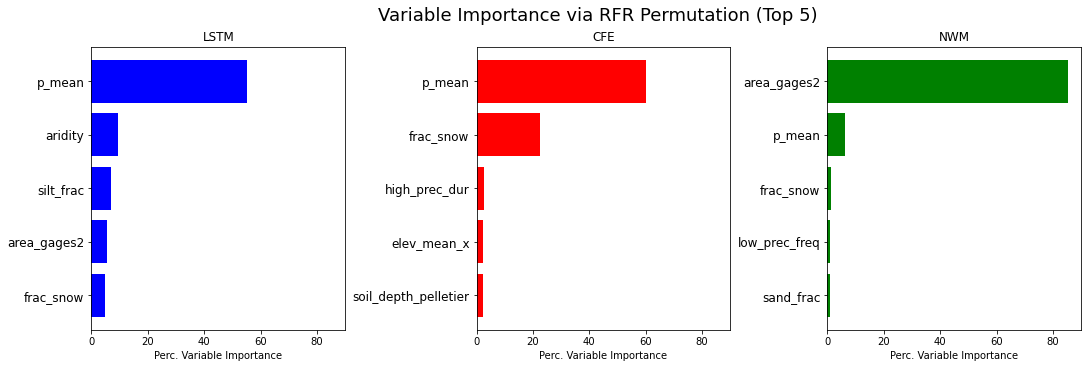

In [23]:
plt.rcParams['figure.figsize'] = (15, 5)

def getList(r, ax, c, topn=5):

    features = featureimportance[0].shape[0] # NUMBER OF FEATURES
    sum = np.zeros((features, ))
    ss = np.zeros((features, ))
    for i in r:
        # POOL MEANS AND STANDARD DEVIATIONS:
        # - GROUP MEAN IS MEAN OF ALL MEANS 
        # - GROUP STD IS DEFINED BY SQRT(SUM(STDs^2)), SINCE ALL SAMPLE SIZES ARE EQUAL
        currdf = featureimportance[i]
        sum = sum + np.abs(currdf[str(i) + "_mean"].to_numpy()).T
        ss =  ss + currdf[str(i) + "_std"].to_numpy().T

    means = sum / len(featureimportance)
    means = means/means.sum() * 100 # NORMALIZE TO PERCENT
    
    std = np.sqrt(ss)  
    
    ind = np.argsort(means)[-topn:]
    
    labels = featureimportance[0].index.values[ind]
    selmeans = means[ind]
    
    # REVERSE TO SHOW IN DESCENDING ORDER
    #selmeans = selmeans[::-1]
    #labels = labels[::-1]
    
    ax.barh(np.arange(selmeans.shape[0]), selmeans, color=c)
    ax.set_yticks(np.arange(selmeans.shape[0]))
    ax.set_yticklabels(labels, fontsize=12)
    ax.set_xlim((0, 90))
    ax.set_xlabel("Perc. Variable Importance")
    
    return ax

plt.rcParams['figure.figsize'] = (15, 5)
figs, axs = plt.subplots(1,3, constrained_layout=True, facecolor="white")


figs.suptitle('Variable Importance via RFR Permutation (Top 5)', fontsize=18, x=0.55)
axs[0] = getList(lstm_idx, axs[0], 'blue')
axs[0].set_title("LSTM")
axs[1] = getList(cfe_idx, axs[1], 'red')
axs[1].set_title("CFE")
axs[2] = getList(nwm_idx, axs[2], 'green')
axs[2].set_title("NWM")

In [24]:
lstm_trainr2  = np.array(metrics[0])[lstm_idx]
lstm_testr2   = np.array(metrics[1])[lstm_idx]
lstm_trainmse = np.array(metrics[2])[lstm_idx]
lstm_testmse  = np.array(metrics[3])[lstm_idx]


cfe_trainr2  = np.array(metrics[0])[cfe_idx]
cfe_testr2   = np.array(metrics[1])[cfe_idx]
cfe_trainmse = np.array(metrics[2])[cfe_idx]
cfe_testmse  = np.array(metrics[3])[cfe_idx]

nwm_trainr2  = np.array(metrics[0])[nwm_idx]
nwm_testr2   = np.array(metrics[1])[nwm_idx]
nwm_trainmse = np.array(metrics[2])[nwm_idx]
nwm_testmse  = np.array(metrics[3])[nwm_idx]

(15, 396)
(15, 396, 3)
(1980,)
(1980,)


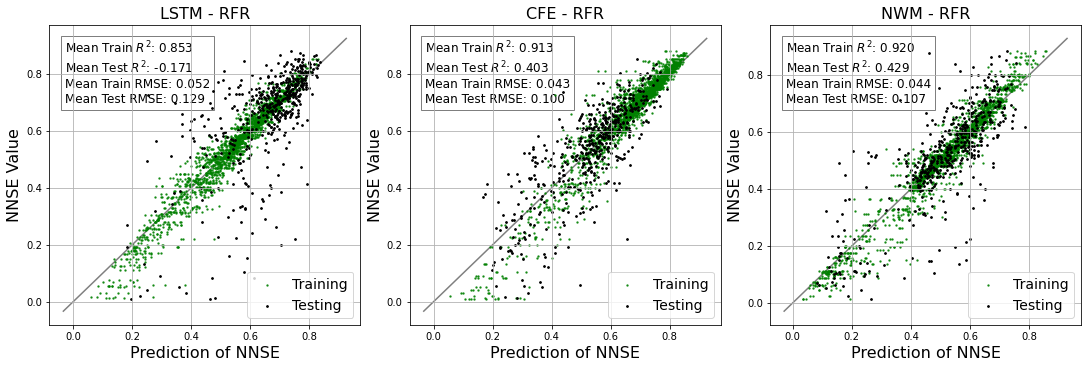

In [29]:
def prettify(ax, title, string):
    props = dict(facecolor='white', alpha=0.5)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Prediction of NNSE", fontsize=16)
    ax.set_ylabel("NNSE Value", fontsize=16)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=.5, zorder=0)
    ax.text(0.05, 0.95, string, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props, zorder=0)
    ax.legend(loc="lower right", fontsize=14)
    ax.grid()
    return ax

def getTrain(trainlists):
    x, y = trainlists
    x = np.array(x)
    y = np.array(y)
    print(x.shape)
    print(y.shape)
    
    x_cfe = x[cfe_idx,:].flatten()
    y_cfe = y[cfe_idx,:,cfe_i].flatten()
    
    x_lstm = x[lstm_idx].flatten()
    y_lstm = y[lstm_idx,:, lstm_i].flatten()
    
    x_nwm = x[nwm_idx].flatten()
    y_nwm = y[nwm_idx,:, nwm_i].flatten()
    
    return x_cfe, y_cfe, x_lstm, y_lstm, x_nwm, y_nwm

pred_cfe, true_cfe, pred_lstm, true_lstm, pred_nwm, true_nwm = getTrain(trainlists)

print(pred_cfe.shape)
print(true_cfe.shape)

cfestr = f"Mean Train $R^2$: {cfe_trainr2.mean():.3f}\nMean Test $R^2$: {cfe_testr2.mean():.3f}\nMean Train RMSE: {np.sqrt(cfe_trainmse.mean()):.3f}\nMean Test RMSE: {np.sqrt(cfe_testmse.mean()):.3f}"
lstmstr = f"Mean Train $R^2$: {lstm_trainr2.mean():.3f}\nMean Test $R^2$: {lstm_testr2.mean():.3f}\nMean Train RMSE: {np.sqrt(lstm_trainmse.mean()):.3f}\nMean Test RMSE: {np.sqrt(lstm_testmse.mean()):.3f}"
nwmstr = f"Mean Train $R^2$: {nwm_trainr2.mean():.3f}\nMean Test $R^2$: {nwm_testr2.mean():.3f}\nMean Train RMSE: {np.sqrt(nwm_trainmse.mean()):.3f}\nMean Test RMSE: {np.sqrt(nwm_testmse.mean()):.3f}"

fig, axs = plt.subplots(1, 3, constrained_layout=True, facecolor="white")

axs[0].scatter(pred_cfe, true_cfe, s=2, color="green", alpha=.75, label="Training")
axs[0].scatter(testvalues[:, lstm_i], outputdataset['LSTM_nnse'], s=3, color="black", label="Testing")

axs[1].scatter(pred_lstm, true_lstm, s=2, color="green", alpha=.75, label="Training")
axs[1].scatter(testvalues[:, cfe_i], outputdataset['CFE_nnse'], s=3, color="black", label="Testing")

axs[2].scatter(pred_nwm, true_nwm, s=2, color="green", alpha=.75, label="Training")
axs[2].scatter(testvalues[:, nwm_i], outputdataset['nwm_nnse'], s=3, color="black", label="Testing")


axs[0] = prettify(axs[0], "LSTM - RFR", lstmstr)
axs[1] = prettify(axs[1], "CFE - RFR", cfestr)
axs[2] = prettify(axs[2], "NWM - RFR", nwmstr)

Text(0, 0.5, 'NNSE')

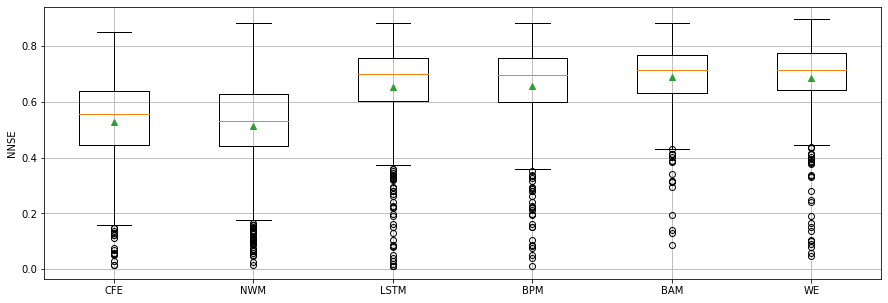

In [10]:
plt.rcParams['figure.figsize'] = (15, 5)
target = outputdataset

# THIS IS THE BEST PREDICTED MODEL
# CALCULATED AS THE MAXIMUM OF THE PREDICTED PERFORMANCES
# BEST PRED MODEL = BPM
bpm_idx = np.argmax(testvalues, axis=1)
bpm_perf = testvalues[np.arange(testvalues.shape[0]), bpm_idx]

# THIS IS THE BEST ACTUAL MODEL
# CALCULATED AS THE MAXIMUM OF THE ACTUAL PERFORMANCES
# BEST ACTUAL MODEL = BAM
target_perf = target.to_numpy()
bam_idx = np.argmax(target_perf, axis=1)
bam_perf = target_perf[np.arange(testvalues.shape[0]), bam_idx]


# ACTUAL MODEL PERFORMANCE = AMP
amp = target.to_numpy()

cfe = amp[:, cfe_i]
cfe_est = testvalues[:, cfe_i]

nwm = amp[:, nwm_i]
nwm_est = testvalues[:, nwm_i]

lstm = amp[:, lstm_i]
lstm_est = testvalues[:, lstm_i]

bestpred_est = testvalues[np.arange(amp.shape[0]), bpm_idx]
bestpred_real = amp[np.arange(amp.shape[0]), bpm_idx]

bestmodel = bam_perf

# perf_models = [cfe_est, cfe, lstm_est, lstm, bestpred_est, bestpred_real, bestmodel]
# labs = ["CFE\nRFR", "CFE\nActual", "LSTM\nRFR","LSTM\nActual", "BPM\nRFR", "BPM\nActual", "BAM"]

perf_models = [cfe, nwm, lstm, bestpred_real, bestmodel, nnse]
labs = ["CFE", "NWM", "LSTM", "BPM", "BAM", "WE"]

fig, ax = plt.subplots(facecolor="white")
ax.boxplot(perf_models, labels=labs, showmeans=True)
ax.grid()
ax.set_ylabel("NNSE")

Text(0, 0.5, 'NNSE')

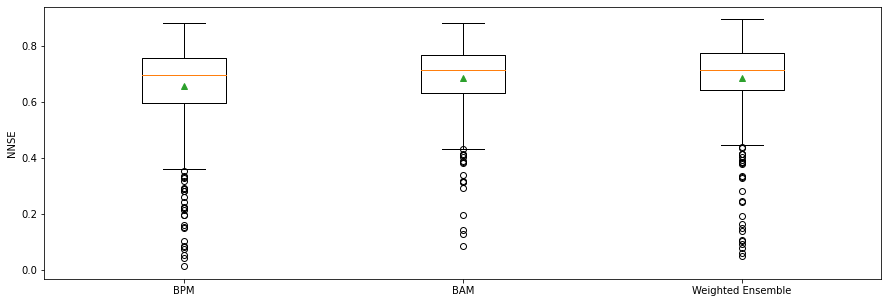

In [11]:


perf_models = [bestpred_real, bestmodel, nnse]
labs = ["BPM", "BAM", "Weighted Ensemble"]
# 

plt.boxplot(perf_models, labels=labs, showmeans=True)
plt.ylabel("NNSE")

In [12]:
perf_ensemble = pd.DataFrame(basins, columns=["basin_id"])
perf_ensemble["ensemble"] = nnse


bam_df = camels_df[["hru_id"]].copy()
bam_df['basin_id'] = bam_df['hru_id'].astype(str).str.zfill(8)
bam_df["bam"] = bam_perf
bam_df["bpm"] = bestpred_real

perf_df = bam_df.merge(perf_ensemble, on="basin_id")

perf_df.head()

,hru_id,basin_id,bam,bpm,ensemble
0,1022500,01022500,0.795679,0.795679,0.844059
1,1031500,01031500,0.866430,0.866430,0.836200
2,1047000,01047000,0.833751,0.833751,0.814134
3,1052500,01052500,0.766951,0.766951,0.756785
4,1054200,01054200,0.719024,0.719024,0.690853


261 basins where ensemble outperformed BAM, 315 where outperformed BPM


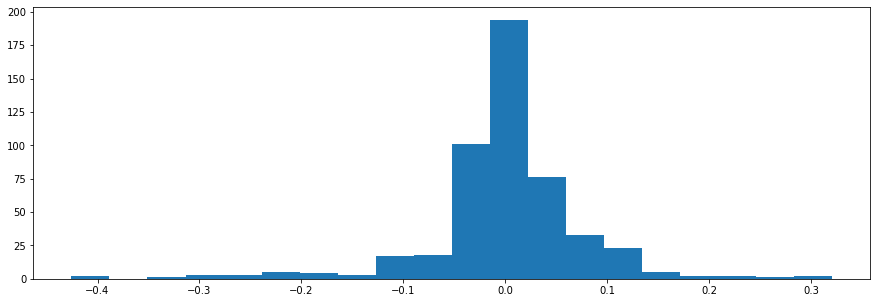

In [13]:
perf = perf_df
perf["ensemble_d"] = perf["ensemble"] - perf["bam"]
perf["ensemble_p"] = perf["ensemble"] - perf["bpm"]
plt.hist(perf["ensemble_d"], bins=20)
print(f'{perf[perf["ensemble_d"] > 0].shape[0]} basins where ensemble outperformed BAM, {perf[perf["ensemble_p"] > 0].shape[0]} where outperformed BPM')

In [14]:
(unique, counts) = np.unique(bpm_idx, return_counts=True)
print(unique)
print(counts)

[0 1 2]
[400  23  72]


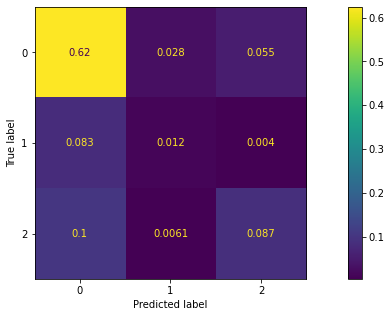

In [15]:
ConfusionMatrixDisplay.from_predictions(bam_idx, bpm_idx, normalize='all')

In [16]:
camels_df

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean_x,ave_T,july_T,Perimeter,geometry,gauge_id_x,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,low_prec_dur,low_prec_timing,gauge_id_y,geol_1st_class,glim_1st_class_frac,geol_2nd_class,glim_2nd_class_frac,carbonate_rocks_frac,geol_porostiy,geol_permeability,gauge_id_x,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean,gauge_id_y,huc_02,gauge_name,gauge_id_x,soil_depth_pelletier,soil_depth_statsgo,soil_porosity,soil_conductivity,max_water_content,sand_frac,silt_frac,clay_frac,water_frac,organic_frac,other_frac,gauge_id_y,gauge_lat,gauge_lon,elev_mean_y,slope_mean,area_gages2,area_geospa_fabric,gauge_id,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99,LSTM_Unnamed: 0,LSTM_basin,LSTM_NSE,LSTM_fold,LSTM_nnse,CFE_basin_id,CFE_nnse,nwm_Unnamed: 0,nwm_basin_id,nwm_nnse,weight_CFE,weight_LSTM,weight_NWM
0,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"POLYGON ((-67.97836 44.61310, -67.97800 44.613...",1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,3.662226,jja,1022500,Acid plutonic rocks,0.590658,Siliciclastic sedimentary rocks,0.164618,0.000000,0.0710,-14.2138,1022500,2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,3.90,2.294118,65.15,17.144737,0.000000,166.25,1022500,1,"Narraguagus River at Cherryfield, Maine",1022500,17.412808,1.491846,0.415905,2.375005,0.626229,59.390156,28.080937,12.037646,1.226913,0.0,0.358472,1022500,44.60797,-67.93524,92.68,17.79072,573.60,620.38,1022500,0.9232,4.871392,3.746692,0.863936,0.337712,0.820493,Mixed Forests,0.237435,2.238444,209,1022500,0.743211,fold_4,0.795679,1022500,0.702071,0,1022500,0.778313,0.000000,0.545250,0.454750
1,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ...",1031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,son,227.35,3.473644,djf,1031500,Siliciclastic sedimentary rocks,0.448928,Metamorphics,0.443863,0.026258,0.0747,-14.8410,1031500,2.030242,0.576289,1.494019,0.445091,1.648693,0.111345,8.010503,18.90,3.286957,94.80,14.697674,0.000000,181.00,1031500,1,"Piscataquis River near Dover-Foxcroft, Maine",1031500,7.252557,1.279047,0.450236,1.373292,0.559123,35.269030,50.841232,12.654125,0.674594,0.0,0.000000,1031500,45.17501,-69.31470,247.80,29.56035,769.05,766.53,1031500,0.9548,4.903259,3.990843,0.870668,0.398619,1.000000,Mixed Forests,0.250000,2.400000,466,1031500,0.845839,fold_9,0.866430,1031500,0.657231,1,1031500,0.757158,0.305542,0.376230,0.318228
2,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"POLYGON ((-70.10847 45.21669, -70.10858 45.216...",1047000,3.323146,2.090024,0.147776,0.280118,0.628929,20.10,1.165217,son,235.90,3.691706,djf,1047000,Metamorphics,0.308488,Acid plutonic rocks,0.288613,0.000000,0.0522,-14.4819,1047000,2.182870,0.656868,1.415939,0.473465,1.510238,0.196458,8.095148,14.95,2.577586,71.55,12.776786,0.000000,184.80,1047000,1,"Carrabassett River near North Anson, Maine",1047000,5.359655,1.392779,0.422749,2.615154,0.561181,55.163133,34.185443,10.303622,0.000000,0.0,0.147867,1047000,44.86920,-69.95510,310.38,49.92122,909.10,904.94,1047000,0.9906,5.086811,4.300978,0.891383,0.445473,0.850450,Mixed Forests,0.241027,2.340180,364,1047000,0.800601,fold_7,0.833751,1047000,0.638119,2,1047000,0.525211,0.434267,0.565733,0.000000
3,1052500,0.0,-71.17197,44.96168,3.961103e+08,646.073604,None,None,172588,"POLYGON ((-71.10862 45.12730, -71.10825 45.127...",1052500,3.730858,2.096423,0.152097,0.352698,0.561914,13.50,1.129707,jja,193.50,2.896707,mam,1052500,Siliciclastic sedimentary rocks,0.497458,Metamorphics,0.374062,0.000000,0.0711,-15.1658,1052500,2.405105,0.644652,1.301062,0.459700,1.025555,0.305965,8.669019,14.10,2.517857,58.90,7.316770,0.000000,197.20,1052

In [17]:
np.count_nonzero(perf_df["ensemble"].to_numpy() > perf_df["bam"].to_numpy())

261

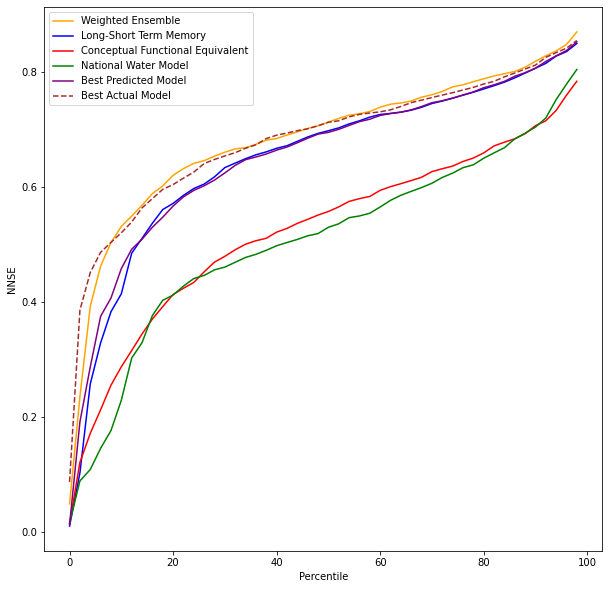

In [18]:
plt.rcParams['figure.figsize'] = (10, 10)

ensemblelist = list()
lstmlist = list()
cfelist = list()
nwmlist = list()
bpmlist = list()
bamlist = list()
quantiles = np.arange(0, 1, 0.02)
for i in quantiles:
    ensemblelist.append(perf_df.ensemble.quantile(i))
    bpmlist.append(perf_df.bpm.quantile(i))
    lstmlist.append(camels_df.LSTM_nnse.quantile(i))
    cfelist.append(camels_df.CFE_nnse.quantile(i))
    nwmlist.append(camels_df.nwm_nnse.quantile(i))
    bamlist.append(perf_df.bam.quantile(i))

    
quantiles = quantiles*100
plt.plot(quantiles, ensemblelist, "Orange",label="Weighted Ensemble")
plt.plot(quantiles, lstmlist, "Blue", label="Long-Short Term Memory")
plt.plot(quantiles, cfelist, "Red", label="Conceptual Functional Equivalent")
plt.plot(quantiles, nwmlist, "Green", label="National Water Model")
plt.plot(quantiles, bpmlist, "Purple", label="Best Predicted Model")
plt.plot(quantiles, bamlist, "brown", linestyle="--", label="Best Actual Model")
plt.xlabel("Percentile")
plt.ylabel("NNSE")
plt.legend()

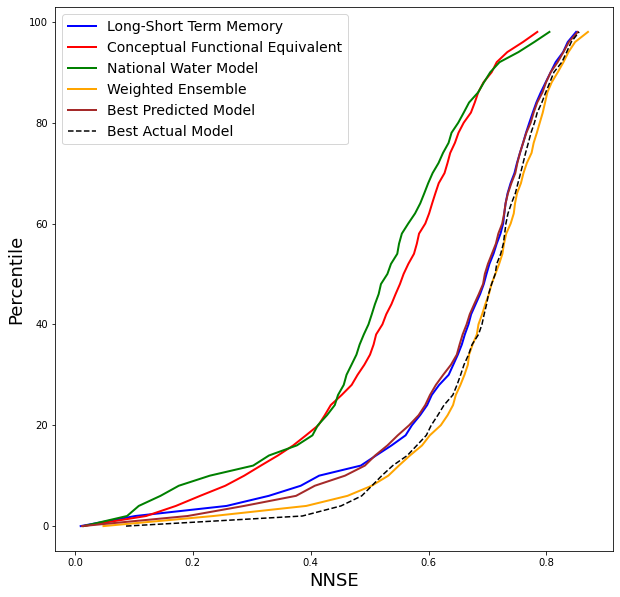

In [19]:
plt.rcParams['figure.figsize'] = (10, 10)

ensemblelist = list()
lstmlist = list()
cfelist = list()
nwmlist = list()
bpmlist = list()
quantiles = np.arange(0, 1, 0.02)
for i in quantiles:
    ensemblelist.append(perf_df.ensemble.quantile(i))
    bpmlist.append(perf_df.bpm.quantile(i))
    lstmlist.append(camels_df.LSTM_nnse.quantile(i))
    cfelist.append(camels_df.CFE_nnse.quantile(i))
    nwmlist.append(camels_df.nwm_nnse.quantile(i))

    
quantiles = quantiles*100

fig, ax = plt.subplots(facecolor="white")

ax.plot(lstmlist, quantiles, "Blue", linewidth=2, label="Long-Short Term Memory")
ax.plot(cfelist, quantiles, "Red", linewidth=2, label="Conceptual Functional Equivalent")
ax.plot(nwmlist, quantiles, "Green", linewidth=2, label="National Water Model")
ax.plot(ensemblelist, quantiles, "Orange", linewidth=2, label="Weighted Ensemble")
ax.plot(bpmlist, quantiles, "brown", linewidth=2, label="Best Predicted Model")
ax.plot(bamlist, quantiles, "black", linestyle="--", label="Best Actual Model")
ax.set_xlabel("NNSE", fontsize=18)
ax.set_ylabel("Percentile", fontsize=18)
ax.legend(fontsize=14)

In [20]:
camels_df.head(5)

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean_x,ave_T,july_T,Perimeter,geometry,gauge_id_x,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,low_prec_dur,low_prec_timing,gauge_id_y,geol_1st_class,glim_1st_class_frac,geol_2nd_class,glim_2nd_class_frac,carbonate_rocks_frac,geol_porostiy,geol_permeability,gauge_id_x,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean,gauge_id_y,huc_02,gauge_name,gauge_id_x,soil_depth_pelletier,soil_depth_statsgo,soil_porosity,soil_conductivity,max_water_content,sand_frac,silt_frac,clay_frac,water_frac,organic_frac,other_frac,gauge_id_y,gauge_lat,gauge_lon,elev_mean_y,slope_mean,area_gages2,area_geospa_fabric,gauge_id,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99,LSTM_Unnamed: 0,LSTM_basin,LSTM_NSE,LSTM_fold,LSTM_nnse,CFE_basin_id,CFE_nnse,nwm_Unnamed: 0,nwm_basin_id,nwm_nnse,weight_CFE,weight_LSTM,weight_NWM
0,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,None,None,312624,"POLYGON ((-67.97836 44.61310, -67.97800 44.613...",1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,3.662226,jja,1022500,Acid plutonic rocks,0.590658,Siliciclastic sedimentary rocks,0.164618,0.000000,0.0710,-14.2138,1022500,2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,3.90,2.294118,65.15,17.144737,0.0,166.25,1022500,1,"Narraguagus River at Cherryfield, Maine",1022500,17.412808,1.491846,0.415905,2.375005,0.626229,59.390156,28.080937,12.037646,1.226913,0.0,0.358472,1022500,44.60797,-67.93524,92.68,17.79072,573.60,620.38,1022500,0.9232,4.871392,3.746692,0.863936,0.337712,0.820493,Mixed Forests,0.237435,2.238444,209,1022500,0.743211,fold_4,0.795679,1022500,0.702071,0,1022500,0.778313,0.000000,0.545250,0.454750
1,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,None,None,309614,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ...",1031500,3.522957,2.071324,0.104091,0.291836,0.587950,18.90,1.148936,son,227.35,3.473644,djf,1031500,Siliciclastic sedimentary rocks,0.448928,Metamorphics,0.443863,0.026258,0.0747,-14.8410,1031500,2.030242,0.576289,1.494019,0.445091,1.648693,0.111345,8.010503,18.90,3.286957,94.80,14.697674,0.0,181.00,1031500,1,"Piscataquis River near Dover-Foxcroft, Maine",1031500,7.252557,1.279047,0.450236,1.373292,0.559123,35.269030,50.841232,12.654125,0.674594,0.0,0.000000,1031500,45.17501,-69.31470,247.80,29.56035,769.05,766.53,1031500,0.9548,4.903259,3.990843,0.870668,0.398619,1.000000,Mixed Forests,0.250000,2.400000,466,1031500,0.845839,fold_9,0.866430,1031500,0.657231,1,1031500,0.757158,0.305542,0.376230,0.318228
2,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,None,None,310157,"POLYGON ((-70.10847 45.21669, -70.10858 45.216...",1047000,3.323146,2.090024,0.147776,0.280118,0.628929,20.10,1.165217,son,235.90,3.691706,djf,1047000,Metamorphics,0.308488,Acid plutonic rocks,0.288613,0.000000,0.0522,-14.4819,1047000,2.182870,0.656868,1.415939,0.473465,1.510238,0.196458,8.095148,14.95,2.577586,71.55,12.776786,0.0,184.80,1047000,1,"Carrabassett River near North Anson, Maine",1047000,5.359655,1.392779,0.422749,2.615154,0.561181,55.163133,34.185443,10.303622,0.000000,0.0,0.147867,1047000,44.86920,-69.95510,310.38,49.92122,909.10,904.94,1047000,0.9906,5.086811,4.300978,0.891383,0.445473,0.850450,Mixed Forests,0.241027,2.340180,364,1047000,0.800601,fold_7,0.833751,1047000,0.638119,2,1047000,0.525211,0.434267,0.565733,0.000000
3,1052500,0.0,-71.17197,44.96168,3.961103e+08,646.073604,None,None,172588,"POLYGON ((-71.10862 45.12730, -71.10825 45.127...",1052500,3.730858,2.096423,0.152097,0.352698,0.561914,13.50,1.129707,jja,193.50,2.896707,mam,1052500,Siliciclastic sedimentary rocks,0.497458,Metamorphics,0.374062,0.000000,0.0711,-15.1658,1052500,2.405105,0.644652,1.301062,0.459700,1.025555,0.305965,8.669019,14.10,2.517857,58.90,7.316770,0.0,197.20,1052500,1,"Diamond River

In [21]:
def prettify(ax, title, string):
    props = dict(facecolor='white', alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("Prediction of NNSE")
    ax.set_ylabel("NNSE Value")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=.5, zorder=0)
    ax.text(0.05, 0.95, string, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props, zorder=0)
    ax.legend(loc="lower right")
    ax.grid()
    return ax

NameError: name 'bin_edges' is not defined

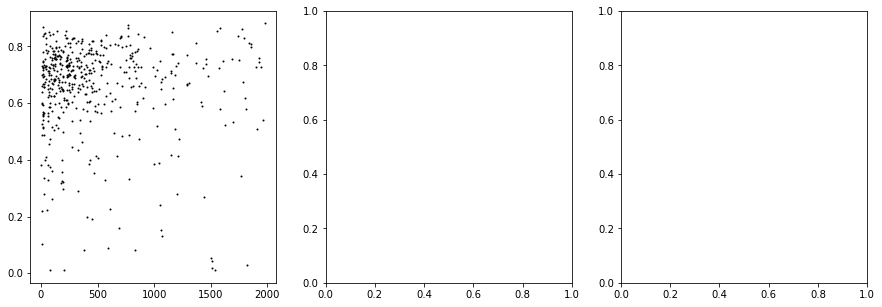

In [22]:
from scipy import stats
plt.rcParams['figure.figsize'] = (15, 5)

fig, axs = plt.subplots(1, 3)

axs[0].plot(camels_df["area_gages2"], camels_df["LSTM_nnse"], '.k', markersize=2)
axs[0].plot(bin_edges[1:], bin_means, '-r')
axs[1].plot(camels_df["area_gages2"], camels_df["CFE_nnse"], '.k', markersize=2)
bin_means, bin_edges, binnumber = stats.binned_statistic(camels_df["area_gages2"], camels_df["CFE_nnse"], statistic='mean', bins=15)
axs[1].plot(bin_edges[1:], bin_means, '-r')
axs[2].plot(camels_df["area_gages2"], camels_df["nwm_nnse"], '.k', markersize=2)
bin_means, bin_edges, binnumber = stats.binned_statistic(camels_df["area_gages2"], camels_df["nwm_nnse"], statistic='mean', bins=15)
axs[2].plot(bin_edges[1:], bin_means, '-r')

In [ ]:
plt.rcParams['figure.figsize'] = (15, 15)

def myplot(ax, name, model):
    bin_means, bin_edges, binnumber = stats.binned_statistic(camels_df[name], camels_df[model], statistic='mean', bins=15)
    bin_edges_spec = (bin_edges[1:] + bin_edges[:-1]) / 2
    ax.plot(camels_df[name], camels_df[model], '.k', markersize=2)
    ax.plot(bin_edges_spec, bin_means, '-r')
    ax.set_ylabel("NNSE")
    ax.set_xlabel(name)
    return ax

def plotVariables(axs, name):
    
    axs[0] = myplot(axs[0], name, "LSTM_nnse")
    axs[1] = myplot(axs[1], name, "CFE_nnse")
    axs[2] = myplot(axs[2], name, "nwm_nnse")
    return axs


fig, axs = plt.subplots(4,3)
axs[0, :] = plotVariables(axs[0, :], "area_gages2")
axs[1, :] = plotVariables(axs[1, :], "frac_snow")
axs[2, :] = plotVariables(axs[2, :], "p_mean")
axs[3, :] = plotVariables(axs[3, :], "aridity")

cols = ["LSTM", "CFE", "NWM"]
rows = ["Basin Area", "Snow Fraction", "Precipitation Mean", "Aridity"]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row)

In [ ]:
fig, axs = plt.subplots(4,3)
axs[0, :] = plotVariables(axs[0, :], "low_prec_dur")
axs[1, :] = plotVariables(axs[1, :], "elev_mean_x")
axs[2, :] = plotVariables(axs[2, :], "silt_frac")
axs[3, :] = plotVariables(axs[3, :], "sand_frac")

cols = ["LSTM", "CFE", "NWM"]
rows = ["Low Precipitation", "Elevation Mean", "Silt Fraction", "Sand Fraction"]

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row)